In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import torch

from sklearn.neighbors import KernelDensity

import datetime
import joblib

from util.data import get_country_df
from models import enc_dec

sns.set()
plt.rcParams['figure.figsize'] = (12, 5)

# Running Anomaly Detection
At this point we have trained an auto encoder on stable country data, and it's time to run actual anomaly detection. To illustrate anomaly detection I've selected two countries that the auto encoder did not see during training. One stable and the other unstable. We will run anomaly detection on events from both countries, and we expect to see higher levels of anomalous activity from the unstable country. 

## Loading Nigeria and Switzerland:
Our two countries are Nigeria and Switzerland. We know that in recent history there have been high levels of conflict and violence in Nigeria, while the opposite is true of Switzerland. 

In [2]:
# Get country data, sort by date:
nga_df = get_country_df('Nigeria', 'data/icews/')
swi_df = get_country_df('Switzerland', 'data/icews/')

nga_df = nga_df.sort_values(by='Event Date').reset_index(drop=True)
swi_df = swi_df.sort_values(by='Event Date').reset_index(drop=True)

nga_df = nga_df.set_index(['Event Date'])
swi_df = swi_df.set_index(['Event Date'])

loading data/icews/icews_nigeria_raw.parquet... done.
loading data/icews/icews_switzerland_raw.parquet... done.


In [3]:
drop = ['Source Country', 'Target Country',
        'Country', 'Latitude', 'Longitude',
        'Event ID', 'Source Name', 
        'Source Sectors','Target Name', 
        'Target Sectors',
        'Story ID','Sentence Number', 
        'Publisher', 'District',
        'Province', 'City']

swi_df = swi_df.drop(drop, axis=1)
nga_df = nga_df.drop(drop, axis=1)

In [4]:
nga_df.head(3)

,Event Text,CAMEO Code,Intensity,QuadClass
Event Date,,,,
2014-01-02,Use unconventional violence,18,-9.0,4
2014-01-02,Make an appeal or request,2,3.0,2
2014-01-02,Provide aid,7,7.0,1


## Pre-processing Country Data
Each of the two country's data must be pre-processed before going through the auto-encoder. For this purpose, we load `OneHotEncoder` object that was previously fit to the entire ICEWS dataset and captures all categories from it. 

In [5]:
# load saved one-hot-encoder and kde
ohe = joblib.load('data/models/ohe.joblib')
kde = joblib.load('data/models/kde.joblib')

In [6]:
# encode unstable country data:
ohu_data = ohe.transform(nga_df['Event Text'].to_numpy().reshape(-1, 1))
ohu_data = pd.DataFrame(ohu_data, columns=ohe.categories_[0], index=nga_df.index)

In [7]:
# encode stable country data:
ohs_data = ohe.transform(swi_df['Event Text'].to_numpy().reshape(-1, 1))
ohs_data = pd.DataFrame(ohs_data, columns=ohe.categories_[0], index = swi_df.index)

In [8]:
# Add one-hot columns to nigeria dataframe
nga_df = pd.concat([nga_df, ohu_data], axis=1)
nga_df.drop(['Event Text'], axis=1, inplace=True)

# add one-hot columns to switzerland dataframe
swi_df = pd.concat([swi_df, ohs_data], axis=1)
swi_df.drop(['Event Text'], axis=1, inplace=True)

## Perform Anomaly Detection
Here we will load the pre-trained auto-encoder and run anomaly detection on each of the two countries. 

In [9]:
# Define auto encoder architecture
hidden_layers = (100, 75, 50, 75, 100)
input_size = nga_df.shape[1]
output_size = input_size

# Create model and load pre-trained weights, set to eval mode:
model = fc.FCNetwork(input_size, hidden_layers, output_size)
model.load_state_dict(torch.load('data/models/ae1.pt', map_location=torch.device('cpu')))
model = model.eval();

In [10]:
# Get auto encoder loss for nigeria
with torch.no_grad():
    x = torch.tensor(nga_df.to_numpy())
    x_hat = model(x)
    ng_mae = (x - x_hat).abs().mean(dim=1)
    
# Get auto encoder loss for switzerland
with torch.no_grad():
    x = torch.tensor(swi_df.to_numpy())
    x_hat = model(x)
    sw_mae = (x - x_hat).abs().mean(dim=1)

In [11]:
nga_df = nga_df.assign(Anomaly= ['Anomaly' if i > 0.03 else 'Normal' for i in ng_mae])
swi_df = swi_df.assign(Anomaly= ['Anomaly' if i > 0.03 else 'Normal' for i in sw_mae])

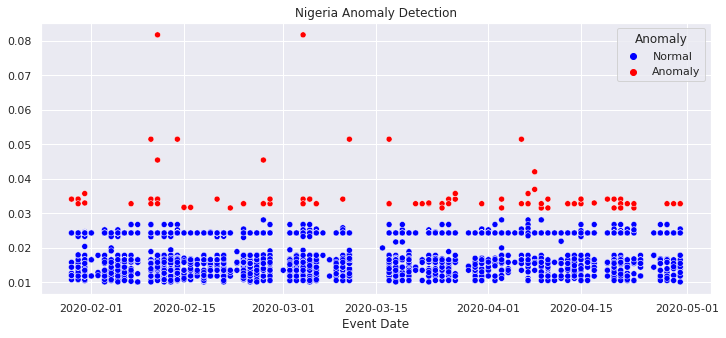

In [12]:
h = ['blue', 'red']
sns.scatterplot(x=nga_df.index[-3000:], y=ng_mae[-3000:], hue=nga_df.Anomaly[-3000:], palette=h)
plt.gca().set(title='Nigeria Anomaly Detection')
plt.show()

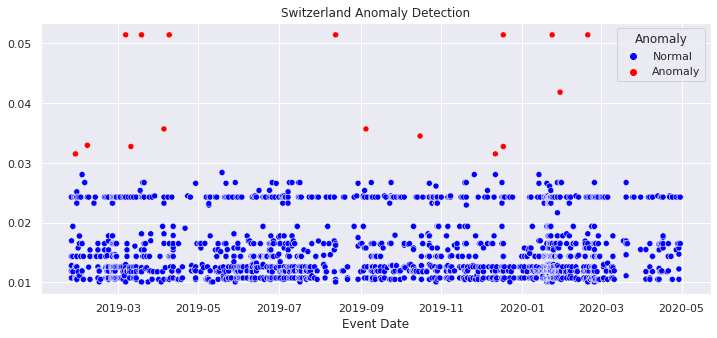

In [13]:
sns.scatterplot(x=swi_df.index[-3000:], y=sw_mae[-3000:], hue=swi_df.Anomaly[-3000:], palette=h)
plt.gca().set(title='Switzerland Anomaly Detection')
plt.show()

In [14]:
# Generate breakdown of anomalous events in Switzerland:
swi_anoms = swi_df[swi_df.Anomaly=='Anomaly']
decoded = ohe.inverse_transform(swi_anoms.iloc[:, 3:-1])
swi_anoms = swi_anoms.assign(Event=decoded)

# Show anomalous events:
swi_anoms.Event.value_counts()

Make an appeal or request                      147
Provide humanitarian aid                        41
Deny responsibility                             35
Return, release person(s)                       33
Provide aid                                     30
Declare truce, ceasefire                        26
Cooperate militarily                            24
Provide economic aid                            20
Retreat or surrender militarily                 14
Provide military aid                            14
Grant asylum                                     6
Ease economic sanctions, boycott, embargo        5
Engage in symbolic act                           5
Return, release property                         5
Engage in judicial cooperation                   4
Receive deployment of peacekeepers               4
Provide military protection or peacekeeping      4
Make empathetic comment                          1
Demobilize armed forces                          1
Express accord                 

In [15]:
# Generate breakdown of anomalous events in Switzerland:
nga_anoms = nga_df[nga_df.Anomaly=='Anomaly']
decoded = ohe.inverse_transform(nga_anoms.iloc[:, 3:-1])
nga_anoms = nga_anoms.assign(Event=decoded)

# Show anomalous events:
nga_anoms.Event.value_counts()

Provide humanitarian aid                       1572
Make an appeal or request                      1491
Return, release person(s)                      1235
Provide aid                                     522
Deny responsibility                             485
Provide economic aid                            217
Retreat or surrender militarily                 159
Cooperate militarily                            113
Provide military aid                             74
Engage in symbolic act                           73
Engage in mass killings                          52
Declare truce, ceasefire                         48
Make empathetic comment                          47
Return, release property                         30
Grant asylum                                     26
Receive deployment of peacekeepers               17
Engage in judicial cooperation                   15
Provide military protection or peacekeeping      12
Demobilize armed forces                          10
Express acco